In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

The aim of this notebook is to prepare the raw data for the machine learing processing

In [2]:
# Input and Output Files Names
filename_data_input = 'DATA_RAW_2019.csv'
filename_data_output = 'DATA_ML.csv'

In [3]:
# IMPORTING DATA PRODUCED VIA BuildData
data_raw = pd.read_csv(filename_data_input)
data_raw = data_raw.set_index('symbol')

Remove Rows and Cols with more than 10 Nulls. Fill null sector with unknown. Replace sector name with numeric code. Create a variable "buy_ignore" with value 1 if the 2020 return is >0, 0 otherwise. Fill Nulls with mean.

In [4]:
# CLEANING DATA: Removing Rows and Columns with more than 10 Null values
data_clean = data_raw[data_raw.isnull().sum(axis=1) < 10] # Remove Symbol if number of null greater than 10
data_clean = data_clean.loc[:, data_clean.isnull().sum() <= 10] # Remove columns that have more than 10 null values
data_clean['sector'] = data_clean['sector'].fillna('unknown') # Fill null sector with unknown

In [5]:
# Replace Sector Name with a numeric code
sector = data_clean.sector.unique()
sector = pd.DataFrame(sector)
sector.columns = ['sector']
sector['sector_code'] = np.arange(len(sector))

In [6]:
# Function that assigns a value 1 if the return is positive, 0 otherwise
def buy_ignore (row):
    if row['return'] > 0:
        return 1
    else:
        return 0

In [7]:
#  Create BUY-IGNORE signal, Fill others null values with column mean, Create a sub dataset with independent variables only
DATA = data_clean.reset_index().merge(sector, how="left").set_index('symbol')
DATA.drop('sector',axis='columns', inplace=True)
DATA['buy_ignore'] = DATA.apply (lambda row: buy_ignore(row), axis=1)

DATA = DATA.apply(lambda x: x.fillna(x.mean()))
DATA_INDEP = DATA.drop(['return', 'buy_ignore'], axis=1)

Standardize Data and create a correlation matrix. To avoid multi-collinearity, remove columns with correlation >0.80

In [8]:
# Standardize DATA (with exception of sector_code)
for col in DATA_INDEP:
    if col != 'sector_code':
        DATA_INDEP[col] = (DATA_INDEP[col] - DATA_INDEP[col].mean())/DATA_INDEP[col].std()

In [9]:
# Analysis of Correlation and dropping of highly correlated variables
cor_matrix = DATA_INDEP.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool)) # Upper Triangle of the Corr Matrix
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)] # Columns with a correlation > 0.80
DATA_INDEP = DATA_INDEP.drop(columns=[col for col in DATA_INDEP if col in to_drop]) # Drop Columns which are in the list to_drop

cor_matrix_new = DATA_INDEP.corr()

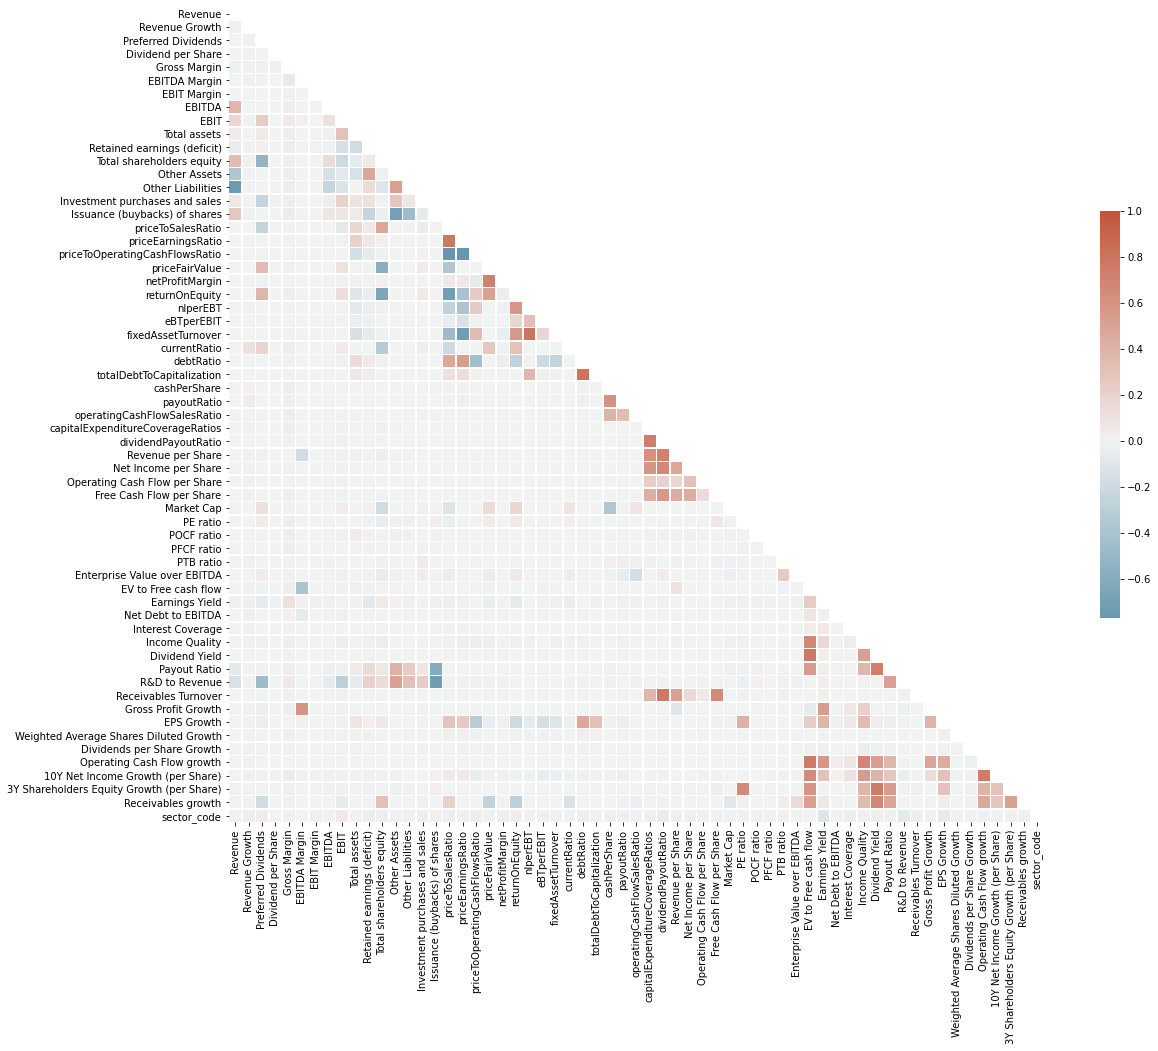

In [10]:
# Visualize New Corr Matrix 

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cor_matrix_new, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cor_matrix_new, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [11]:
# Data to be used for Machine Learning Alghoritms
y = DATA['buy_ignore']
y = pd.DataFrame(y).reset_index()
DATA_ML = DATA_INDEP.reset_index().merge(y, how="left").set_index('symbol')
DATA_ML.to_csv(filename_data_output)